In [1]:
import numpy as np
from scipy.stats import ttest_rel
import pandas as pd
import seaborn as sns
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
from scipy.stats import ttest_rel, wilcoxon
from scipy.signal import decimate
from scipy.spatial.distance import jensenshannon

In [6]:
def load_files(skip_mode, recalled, metric, by_elec):
    
    if by_elec:
        file_id = 'by_elec'
    else:
        file_id = 'by_subj'
    
    if recalled:
        recall_str = "recalled"
        skip_mode = [0,1] # automatically skip 0/1 (correct/not correct) for recalled trials
    else:
        recall_str = ""
    
    theta_pac_data = {f'{metric}': [], f'{metric}_z': [], 'p_val': [], 'subj': [], 'mode': [], 'Gamma-band': []}
    subjects_by_mode = {}
    for i in range(4):
        if i in skip_mode:
            continue 
            
        if i == 2:
            mode = 'Not clust'
        if i == 3:
            mode = 'Clust'
        
        subjects_by_mode[i] = []
        vals_hg = dict(np.load(f'saved_results/hg_{metric}_{file_id}_{i}{recall_str}.npz'))
        vals_lg = dict(np.load(f'saved_results/lg_{metric}_{file_id}_{i}{recall_str}.npz'))
        
        vals_z_hg = dict(np.load(f'saved_results/hg_{metric}_{file_id}_z_{i}{recall_str}.npz'))
        vals_z_lg = dict(np.load(f'saved_results/lg_{metric}_{file_id}_z_{i}{recall_str}.npz'))
        
        p_vals_hg = dict(np.load(f'saved_results/hg_{metric}_p_vals_{file_id}_{i}{recall_str}.npz'))
        p_vals_lg = dict(np.load(f'saved_results/lg_{metric}_p_vals_{file_id}_{i}{recall_str}.npz'))
        
        for subj in vals_hg.keys():
            
            try:
                
                if metric == 'MI':
                    
                    if by_elec:
                        
                        hg_subj = float(vals_hg[subj])
                        lg_subj = float(vals_lg[subj])

                        hg_subj_z = float(vals_z_hg[subj])
                        lg_subj_z = float(vals_z_lg[subj])

                        hg_p_subj = float(p_vals_hg[subj])
                        lg_p_subj = float(p_vals_lg[subj])
                        
                    else:
                        
                        hg_subj = vals_hg[subj][0]
                        lg_subj = vals_lg[subj][0]

                        hg_subj_z = vals_z_hg[subj][0]
                        lg_subj_z = vals_z_lg[subj][0]

                        hg_p_subj = p_vals_hg[subj][0]
                        lg_p_subj = p_vals_lg[subj][0]
                    
                elif metric == 'MOVI':
       
                    hg_subj = vals_hg[subj]
                    lg_subj = vals_lg[subj]

                    hg_subj_z = vals_z_hg[subj]
                    lg_subj_z = vals_z_lg[subj]

                    hg_p_subj = p_vals_hg[subj]
                    lg_p_subj = p_vals_lg[subj]
                    
                
                theta_pac_data[f'{metric}'].extend([hg_subj, lg_subj])
                theta_pac_data[f'{metric}_z'].extend([hg_subj_z, lg_subj_z])
                theta_pac_data['p_val'].extend([hg_p_subj, lg_p_subj])
                theta_pac_data['subj'].extend([subj, subj])
                theta_pac_data['mode'].extend([mode, mode])
                theta_pac_data['Gamma-band'].extend(['High gamma', 'Low gamma'])
                
                              
                subjects_by_mode[i].append(subj)
                
                
            except: 
                pass
            
    return pd.DataFrame(theta_pac_data), subjects_by_mode

def remove_low_theta_elec(recalled, theta_pac_pd, threshold=0.3):
    
    if recalled:
        theta_elec = pd.DataFrame(dict(np.load('updated_data/high_theta_frac_trials_recalled.npz')), index=['FHT']).T
    else:
        theta_elec = pd.DataFrame(dict(np.load('updated_data/high_theta_frac_trials_encoding.npz')), index=['FHT']).T
        
    theta_elec_high = theta_elec.loc[theta_elec['FHT'] > threshold]
    
    theta_pac_pd_high_theta = theta_pac_pd.loc[theta_pac_pd['subj'].isin(list(theta_elec_high.index))]
    
    return theta_pac_pd_high_theta

def compute_stats_test(gamma_type, PAC_SME_df, modes, y_val, tstat=False):
    
    PAC_SME_df_g = PAC_SME_df.loc[PAC_SME_df['Gamma-band']==gamma_type]
    
    if tstat: 
        
        t,p = ttest_rel(PAC_SME_df_g.loc[PAC_SME_df_g['mode']==modes[0]][y_val].values, 
        PAC_SME_df_g.loc[PAC_SME_df_g['mode']==modes[1]][y_val].values)

        return t,p
        
    
    else:
        res = wilcoxon(PAC_SME_df_g.loc[PAC_SME_df_g['mode']==modes[0]][y_val].values, 
        PAC_SME_df_g.loc[PAC_SME_df_g['mode']==modes[1]][y_val].values)

        return res.statistic, res.pvalue

def generate_figures(pd_data, y_val, modes, by_elec, recalled, tstat_bool=True):
    
    if by_elec:
        file_id = 'by_elec'
    else:
        file_id = 'by_subj'
        
    if recalled:
        print("Plotting recalled data")
        recall_str = '_recalled'
    else:
        recall_str = ''
    
    PAC_SME = pd_data.groupby(['subj', 'mode', 'Gamma-band'])[y_val].mean()
    
    PAC_SME_df = {'subj': [], 'mode': [], 'Gamma-band': [],  y_val: []}
    for idx, val in zip (PAC_SME.index, PAC_SME.values):
        PAC_SME_df['subj'].append(idx[0])
        PAC_SME_df['mode'].append(idx[1])
        PAC_SME_df['Gamma-band'].append(idx[2])
        PAC_SME_df[y_val].append(val)
        
    PAC_SME_df = pd.DataFrame(PAC_SME_df)
    
    t1, p1 = compute_stats_test('High gamma', PAC_SME_df, modes, y_val, tstat=tstat_bool)
    t2, p2 = compute_stats_test('Low gamma', PAC_SME_df, modes, y_val, tstat=tstat_bool)
    
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    sns.stripplot(data=PAC_SME_df,  x='Gamma-band', y=y_val, hue='mode', size=6, dodge=True, ax=ax, legend=False, palette='tab10')
    for i in range(0, 4, 2):
        locs1 = ax.get_children()[i].get_offsets()
        locs2 = ax.get_children()[i+1].get_offsets()
        for i in range(locs1.shape[0]):
            x = [locs1[i, 0], locs2[i, 0]]
            y = [locs1[i, 1], locs2[i, 1]]
            ax.plot(x, y, color="black", alpha=0.2)

    if y_val == 'MI':
        ax.text(0, 0.0034, f'P={round(p1,3)}', ha='center', va='bottom')
        ax.text(1, 0.0034, f'P={round(p2,3)}', ha='center', va='bottom')
    else:
        ax.text(0, np.max(PAC_SME_df[y_val]), f'{round(t1,3)}, P={round(p1,3)}', ha='center', va='bottom')
        ax.text(1, np.max(PAC_SME_df[y_val]), f'{round(t2,3)}, P={round(p2,3)}', ha='center', va='bottom')
 
    sns.boxplot(data=PAC_SME_df, x='Gamma-band', y=y_val, hue='mode', fliersize=0, ax=ax, fill=False, palette='tab10', widths=0.2)
        
    plt.show()
    
def subjects_elec_intersect(subj_dict, modes):
    
    s1 = subj_dict[modes[0]]
    s2 = subj_dict[modes[1]]  

    return np.intersect1d(s1, s2)

def plot_MI_dist(gamma_type, clust_type, by_elec, recalled, remove_low_theta, plot):
    
    if by_elec:
        file_id = 'by_elec'
    else:
        file_id = 'by_subj'
        
    if recalled:
        print("Plotting recalled data")
        recall_str = 'recalled'
        
    else:
        recall_str = ''
    
    dist = pd.DataFrame(dict(np.load(f'saved_results/{gamma_type}_dist_{file_id}_{clust_type}{recall_str}.npz')))
    MI = dict(np.load(f'saved_results/{gamma_type}_MI_{file_id}_{clust_type}{recall_str}.npz'))
    MI_z = dict(np.load(f'saved_results/{gamma_type}_MI_{file_id}_z_{clust_type}{recall_str}.npz'))
    pvals = dict(np.load(f'saved_results/{gamma_type}_MI_p_vals_{file_id}_{clust_type}{recall_str}.npz'))
    
    if by_elec:
        MI_clean = pd.DataFrame({k: float(v) for k, v in MI.items()}, index=['MI'])
        MI_df = MI_clean.T
        MI_z_clean = pd.DataFrame({k: float(v) for k, v in MI_z.items()}, index=['MI_z'])
        MI_z_df = MI_z_clean.T
        p_clean = pd.DataFrame({k: float(v) for k, v in pvals.items()}, index=['Pvals'])
        p_vals_df = p_clean.T
    else:
        MI_clean = pd.DataFrame({k: v for k, v in MI.items() if len(v)!=0})
        MI_df = MI_clean.T

        MI_z_clean = pd.DataFrame({k: v for k, v in MI_z.items() if len(v)!=0})
        MI_z_df = MI_z_clean.T
 
    dist.index *= 20
    df = dist.T
    df['MaxIndex'] = np.argmax(df.values, axis=1)
    sorted_df = df.sort_values(by='MaxIndex')
    sorted_df = sorted_df.drop('MaxIndex', axis=1)
    
    MI_z_sig = MI_z_df[MI_z_df.values >= 1.96]
    p_sig = p_vals_df[p_vals_df.values < 0.05]
    print("Fraction of sig p vals: ", p_sig.shape[0]/p_vals_df.shape[0])
    df_filtered = sorted_df.loc[p_sig.index]
    df_filtered_by_MI = sorted_df.loc[MI_z_sig.index]
    
    sorted_df = sorted_df.rename_axis('subj', axis=0).reset_index()
    df_filtered = df_filtered.rename_axis('subj', axis=0).reset_index()
    

    if plot:
        
        plt.figure(figsize=(12,12))
        sns.heatmap(sorted_df, vmin=0.035, vmax=0.10)
        plt.title(f"Gamma dist by theta phase, {clust_type}, {Gamma-band}")
        plt.savefig(f'figures/{file_id}_{Gamma-band}_dist_{clust_type}_{recall_str}', bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(8,6))
        sns.heatmap(df_filtered, vmin=0.04, vmax=.075)
        plt.title(f"Gamma dist by theta phase, {clust_type}, {Gamma-band}")
        plt.savefig(f'figures/{file_id}_{Gamma-band}_dist_{clust_type}_sig_{recall_str}', bbox_inches='tight')
        plt.show()
    
    return sorted_df
    '''
    
    MI_df = MI_df.reindex(sorted_df.index)
    plt.figure(figsize=(2,10))
    sns.heatmap(MI_df)
    plt.title(f"MI values, {clust_type}, {Gamma-band}")
    plt.savefig(f'figures/{file_id}_{Gamma-band}_MI_{clust_type}_{recall_str}', bbox_inches='tight')
    plt.show()
    dist.index*=20
    
    
    pvals = p_vals_df.reindex(p_vals_df.index)
    plt.figure(figsize=(2,10))
    sns.heatmap(pvals)
    plt.title(f"P vals, {clust_type}, {Gamma-band}")
    plt.savefig(f'figures/{file_id}_{Gamma-band}_pvals_{clust_type}_{recall_str}', bbox_inches='tight')
    plt.show()
    '''
    
def compute_js(df_encoding, df_recalled):
    
    # select electrodes that exist in both recalled and encoding data 
    recalled_and_encoding_elecs = np.intersect1d(df_encoding.subj, df_recalled.subj)
    df1 = df_encoding.loc[df_encoding['subj'].isin(recalled_and_encoding_elecs)]
    df2 = df_recalled.loc[df_recalled['subj'].isin(recalled_and_encoding_elecs)]
    
    # compute jensen shannon divergence between encoding theta gamma PAC dist 
    # and recalled theta gamma PAC dist
    js = {}
    for elec in recalled_and_encoding_elecs:
        df1_selec = np.array(df1.loc[df1.subj==elec].drop('subj', axis=1)).squeeze()
        df2_selec = np.array(df2.loc[df2.subj==elec].drop('subj', axis=1)).squeeze()
        js[elec] = jensenshannon(df1_selec, df2_selec)
        
    return js

def remove_non_common_keys(clust, noclust):
    common_keys = set(clust.keys()) & set(noclust.keys())  # Find common keys
    clust = {key: clust[key] for key in common_keys}  # Create new dict1 with common keys
    noclust = {key: noclust[key] for key in common_keys}  # Create new dict2 with common keys
    df = pd.DataFrame({'clust': clust, 'noclust': noclust})
    return df

def z_score(power):
    
    power = (power - np.mean(power)) / np.std(np.mean(power, axis=1),axis=0)
    return power

def z_score_ds_by_sess(sess_dat, power):
    
    power = decimate(power, 10)
    
    power_z = np.zeros_like(power)
    
    for sess in np.unique(sess_dat):
        
        sess_idxs = np.argwhere(sess_dat==sess).squeeze()
        power_z[sess_idxs] = z_score(power[sess_idxs])

    return power_z 

def load_gamma(recalled, min_thresh=30, min_thresh_per_condition=10, zscore_ds=True):
    
    
    gamma_dict = {'Gamma-band': [], 'mode': [], 'subj': [], 'power': []}
    
    if zscore_ds:
        sr = 50 # sampling rate in Hz
    else:
        sr = 500
        
    sr_factor = 1000/sr 
    
    if recalled:
        dd_trials = dict(np.load('updated_data/dd_trials_recall.npz'))
        
        # for recall trials, neural recording 
        # starts from -1000 ms before word onset 
        # and finishes 1000 ms post word onset 
        start_time = -2000
        end_time = 2000
        
        # this is where we are interested in analyzing 
        # -600 to -100 ms (0 ms is word onset)
        ripple_start = -600
        ripple_end = -100
    
    else:
        dd_trials = dict(np.load('updated_data/dd_trials_encoding.npz'))
        
        start_time = -700
        end_time = 2300

        # timepoints of interest
        ripple_start = 400
        ripple_end = 1100

    clust_idxs = np.argwhere(dd_trials['clust_int']==1)
    nonclust_idxs = np.argwhere(dd_trials['clust_int']==0)
    
    # convert to indices based on start time and sampling rate factor
    start_idx = int((ripple_start - start_time)/sr_factor)
    end_idx = int((ripple_end-start_time)/sr_factor)
    
    print(start_idx, end_idx)
    
    too_few = 0
    good_amount = 0
    
    sess = dd_trials['sess']
    
    if zscore_ds:
        high_gamma = z_score_ds_by_sess(sess, np.log10(dd_trials['high_gamma']**2))
        low_gamma = z_score_ds_by_sess(sess, np.log10(dd_trials['low_gamma']**2))
    else:
        high_gamma = np.log10(dd_trials['high_gamma']**2)
        low_gamma = np.log10(dd_trials['low_gamma']**2)
    
    for subj in np.unique(dd_trials['subj']):
        
        subj_idxs = np.argwhere(dd_trials['subj']==subj)
        
        for elec in np.unique(dd_trials['elec_names'][subj_idxs]):
            
            elec_idxs = np.argwhere(dd_trials['elec_names']==elec)
            subj_elec_idxs = np.intersect1d(subj_idxs, elec_idxs)
            
            if subj_elec_idxs.shape[0] < min_thresh:
                too_few += 1
                continue
                
            subj_elec_clust_idxs = np.intersect1d(clust_idxs, subj_elec_idxs)
            subj_elec_nonclust_idxs = np.intersect1d(nonclust_idxs, subj_elec_idxs)
            
            if min(subj_elec_nonclust_idxs.shape[0], subj_elec_clust_idxs.shape[0]) < min_thresh_per_condition:
                too_few += 1
                continue
                
            good_amount+=1
                                       
            hg_nc = np.mean(high_gamma[subj_elec_nonclust_idxs, start_idx:end_idx])
            hg_c = np.mean(high_gamma[subj_elec_clust_idxs, start_idx:end_idx])
            
            lg_nc = np.mean(low_gamma[subj_elec_nonclust_idxs, start_idx:end_idx])
            lg_c = np.mean(low_gamma[subj_elec_clust_idxs, start_idx:end_idx])
            
            gamma_type = ['High gamma', 'Low gamma']
            clust_mode = ['Not clust', 'Clust']
            dat = [hg_nc, hg_c, lg_nc, lg_c]
            i=0
            for g in gamma_type:
                for c in clust_mode:
                    gamma_dict['subj'].append(f'{subj}_{elec}')
                    gamma_dict['mode'].append(c)
                    gamma_dict['power'].append(dat[i])
                    gamma_dict['Gamma-band'].append(g)
                    i+=1
                    
    return pd.DataFrame(gamma_dict), high_gamma, low_gamma, clust_idxs, nonclust_idxs
            

In [7]:
recalled = True

In [8]:
gamma_pd, hg, lg, clust, nonclust = load_gamma(recalled=recalled, min_thresh=30, min_thresh_per_condition=10, zscore_ds=True)

70 95


[]

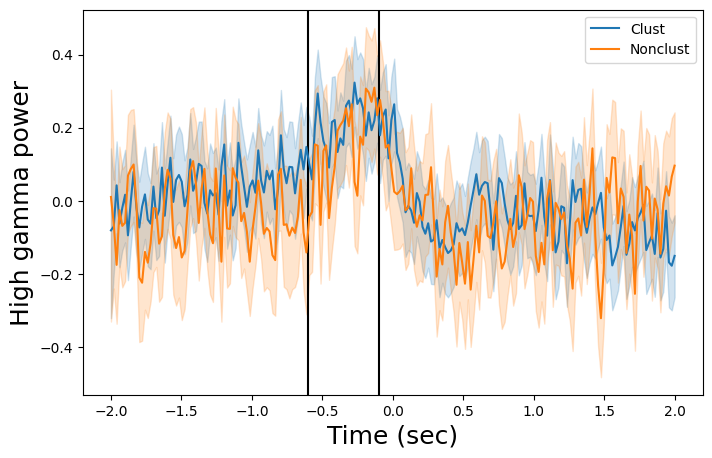

In [9]:
plt.figure(figsize=(8,5))

hg_clust = hg[clust].squeeze()
hg_nonclust = hg[nonclust].squeeze()
hg_recalled = np.vstack((hg_clust, hg_nonclust))
trial_type = np.hstack((np.repeat('Clust', hg_clust.shape[0]), np.repeat('Nonclust', hg_nonclust.shape[0])))

timesteps = hg_recalled.shape[1]

if recalled:
    plt.axvline(-0.6, color='black')
    plt.axvline(-0.1, color='black')
    time = np.linspace(-2, 2, timesteps)
else:
    plt.axvline(0.4, color='black')
    plt.axvline(1.1, color='black')
    time = np.linspace(-.7, 2.3, timesteps)
    

num_trials = hg_recalled.shape[0]
hg_pd = pd.DataFrame({'time': np.tile(time,num_trials), 'hg':np.ravel(hg_recalled), 
                           'Trial': np.repeat(trial_type, timesteps)}) 


sns.lineplot(data=hg_pd, x='time', y='hg', hue='Trial', errorbar=('ci', 95))

plt.ylabel("High gamma power", fontsize=18)
plt.xlabel("Time (sec)", fontsize=18) 
plt.legend()
plt.plot()

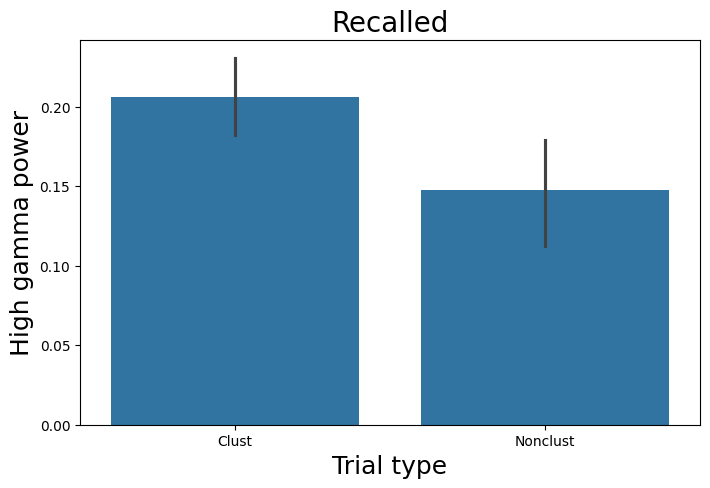

In [10]:
plt.figure(figsize=(8,5))

timesteps = hg.shape[1]

if recalled:
    hg_roi = hg[:, 70:95]
    timesteps = hg_roi.shape[1]
    time = np.linspace(-2, 2, timesteps)
else:
    hg_roi = hg[:, 55:90]
    timesteps = hg_roi.shape[1]
    time = np.linspace(-.7, 2.3, timesteps)
    
hg_clust = hg_roi[clust].squeeze()
hg_nonclust = hg_roi[nonclust].squeeze()
hg_recalled = np.vstack((hg_clust, hg_nonclust))
trial_type = np.hstack((np.repeat('Clust', hg_clust.shape[0]), np.repeat('Nonclust', hg_nonclust.shape[0])))

    

num_trials = hg_recalled.shape[0]
hg_pd = pd.DataFrame({'time': np.tile(time,num_trials), 'hg':np.ravel(hg_recalled), 
                           'Trial': np.repeat(trial_type, timesteps)}) 

sns.barplot(data=hg_pd, x='Trial', y='hg', errorbar=('ci', 95))
plt.ylabel("High gamma power", fontsize=18)
plt.xlabel("Trial type", fontsize=18)
if recalled:
    plt.title("Recalled", fontsize=20)
else:
    plt.title("Encoding", fontsize=20)


Plotting recalled data


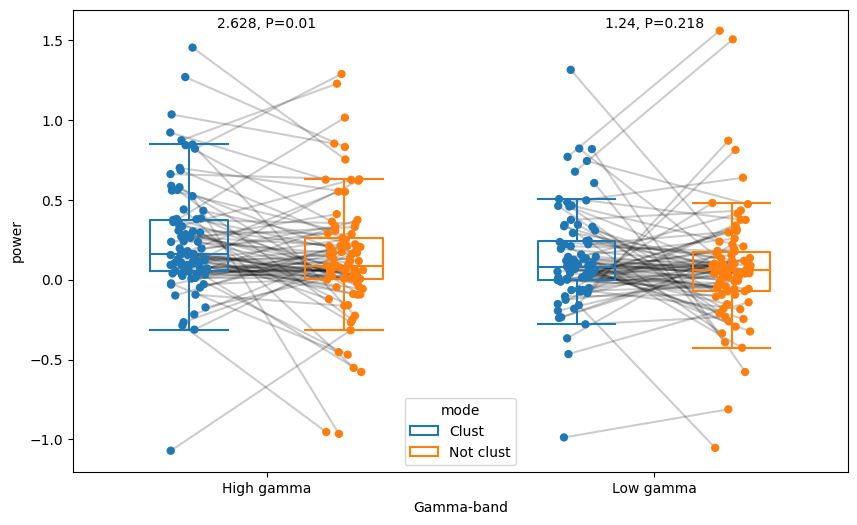

In [11]:
generate_figures(gamma_pd, 'power', ['Clust', 'Not clust'], by_elec=True, recalled=recalled, tstat_bool=True)

In [12]:
theta_pac_pd, subjects_by_mode = load_files(skip_mode = [0, 1], recalled=recalled, metric='MI', by_elec=True)

Plotting recalled data


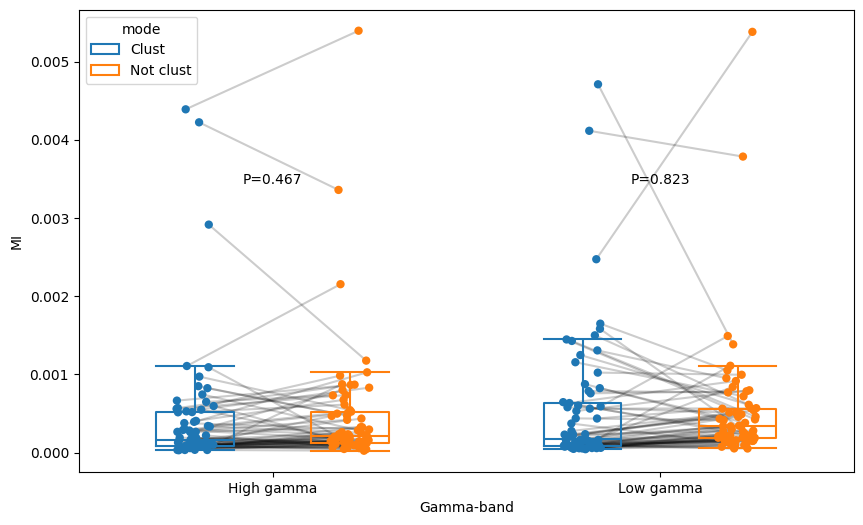

Plotting recalled data


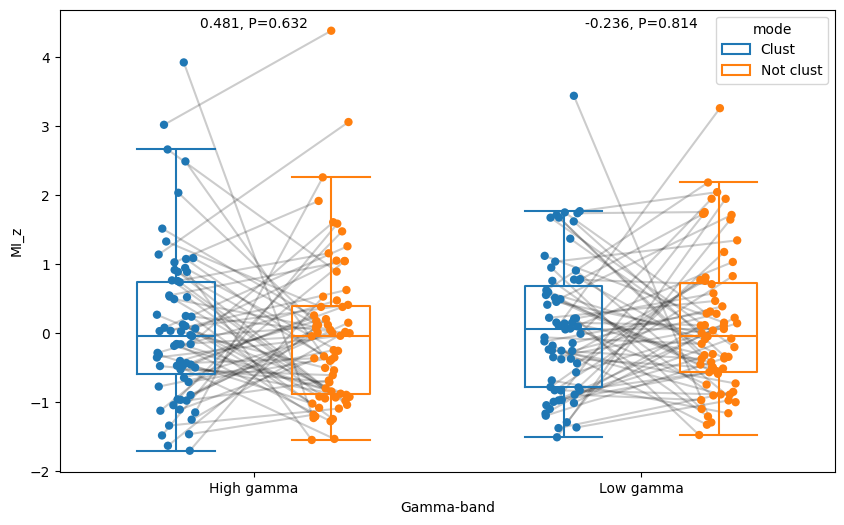

In [13]:
s_intersect_2_3 = subjects_elec_intersect(subjects_by_mode, [2,3])
mask_2_3 = theta_pac_pd['subj'].isin(s_intersect_2_3)
theta_pac_pd_2_3 = theta_pac_pd[mask_2_3]
generate_figures(theta_pac_pd_2_3, 'MI', ['Clust', 'Not clust'], by_elec=True, tstat_bool=True, recalled=recalled)
generate_figures(theta_pac_pd_2_3, 'MI_z', ['Clust', 'Not clust'], by_elec=True, tstat_bool=True, recalled=recalled)
#mask_2_3 = theta_pac_pd_high_theta['subj'].isin(s_intersect_2_3)
#theta_pac_pd_high_theta_2_3 = theta_pac_pd_high_theta[mask_2_3]
#generate_figures(theta_pac_pd_high_theta_2_3, 'MI', ['Clust', 'Not clust'], by_elec=True, tstat_bool=True, recalled=recalled)
#generate_figures(theta_pac_pd_high_theta_2_3, 'MI_z', ['Clust', 'Not clust'], by_elec=True, tstat_bool=True, recalled=recalled)

In [14]:
gamma_type = 'hg'   
sorted_df_recalled_noclust = plot_MI_dist(gamma_type, 2, True, recalled=True, remove_low_theta=False, plot=False)
sorted_df_encoding_noclust = plot_MI_dist(gamma_type, 2, True, recalled=False, remove_low_theta=False, plot=False)
js_noclust = compute_js(sorted_df_encoding_noclust, sorted_df_recalled_noclust)

sorted_df_recalled_clust = plot_MI_dist(gamma_type, 3, True, recalled=True, remove_low_theta=False, plot=False)
sorted_df_encoding_clust = plot_MI_dist(gamma_type, 3, True, recalled=False, remove_low_theta=False, plot=False)
js_clust = compute_js(sorted_df_encoding_clust, sorted_df_recalled_clust)

df_comb = remove_non_common_keys(js_clust, js_noclust)

Plotting recalled data
Fraction of sig p vals:  0.05405405405405406
Fraction of sig p vals:  0.08653846153846154
Plotting recalled data
Fraction of sig p vals:  0.06172839506172839
Fraction of sig p vals:  0.0967741935483871


In [58]:
def plot_MI_dist(gamma_type, clust_type, by_elec, recalled, remove_low_theta, plot):
    
    if by_elec:
        file_id = 'by_elec'
    else:
        file_id = 'by_subj'
        
    if recalled:
        print("Plotting recalled data")
        recall_str = 'recalled'
        
    else:
        recall_str = ''
    
    dist = pd.DataFrame(dict(np.load(f'saved_results/{gamma_type}_dist_{file_id}_{clust_type}{recall_str}.npz')))
    MI = dict(np.load(f'saved_results/{gamma_type}_MI_{file_id}_{clust_type}{recall_str}.npz'))
    MI_z = dict(np.load(f'saved_results/{gamma_type}_MI_{file_id}_z_{clust_type}{recall_str}.npz'))
    pvals = dict(np.load(f'saved_results/{gamma_type}_MI_p_vals_{file_id}_{clust_type}{recall_str}.npz'))
    
    if by_elec:
        MI_clean = pd.DataFrame({k: float(v) for k, v in MI.items()}, index=['MI'])
        MI_df = MI_clean.T
        MI_z_clean = pd.DataFrame({k: float(v) for k, v in MI_z.items()}, index=['MI_z'])
        MI_z_df = MI_z_clean.T
        p_clean = pd.DataFrame({k: float(v) for k, v in pvals.items()}, index=['Pvals'])
        p_vals_df = p_clean.T
    else:
        MI_clean = pd.DataFrame({k: v for k, v in MI.items() if len(v)!=0})
        MI_df = MI_clean.T

        MI_z_clean = pd.DataFrame({k: v for k, v in MI_z.items() if len(v)!=0})
        MI_z_df = MI_z_clean.T
 
    dist.index *= 20
    df = dist.T
    df['MaxIndex'] = np.argmax(df.values, axis=1)
    sorted_df = df.sort_values(by='MaxIndex')
    sorted_df = sorted_df.drop('MaxIndex', axis=1)
    
    MI_z_sig = MI_z_df[MI_z_df.values >= 1.96]
    p_sig = p_vals_df[p_vals_df.values < 0.05]
    print("Fraction of sig p vals: ", p_sig.shape[0]/p_vals_df.shape[0])
    df_filtered = sorted_df.loc[p_sig.index]
    df_filtered_by_MI = sorted_df.loc[MI_z_sig.index]
    
 
    if plot:
        
        if clust_type == 2:
            clust_type = 'No clustered'
        if clust_type == 3:
            clust_type = 'Clustered'
            
        if gamma_type == 'hg':
            gamma_type = 'High gamma'
        elif gamma_type == 'lg':
            gamma_type = 'Low gamma'
        
        
        plt.figure(figsize=(10,12))
        sns.heatmap(sorted_df, vmin=0.035, vmax=0.10)
        plt.title(f"Gamma dist by theta phase, {clust_type}, {gamma_type}")
        plt.savefig(f'figures/{file_id}_{gamma_type}_dist_{clust_type}_{recall_str}', bbox_inches='tight')
        plt.show()

        plt.figure(figsize=(8,6))
        sns.heatmap(df_filtered, vmin=0.04, vmax=.075)
        plt.title(f"Gamma dist by theta phase, {clust_type}, {gamma_type}")
        plt.savefig(f'figures/{file_id}_{gamma_type}_dist_{clust_type}_sig_{recall_str}', bbox_inches='tight')
        plt.show()
        
    sorted_df = sorted_df.rename_axis('subj', axis=0).reset_index()
    df_filtered = df_filtered.rename_axis('subj', axis=0).reset_index()
    
    
    return sorted_df

Fraction of sig p vals:  0.08653846153846154


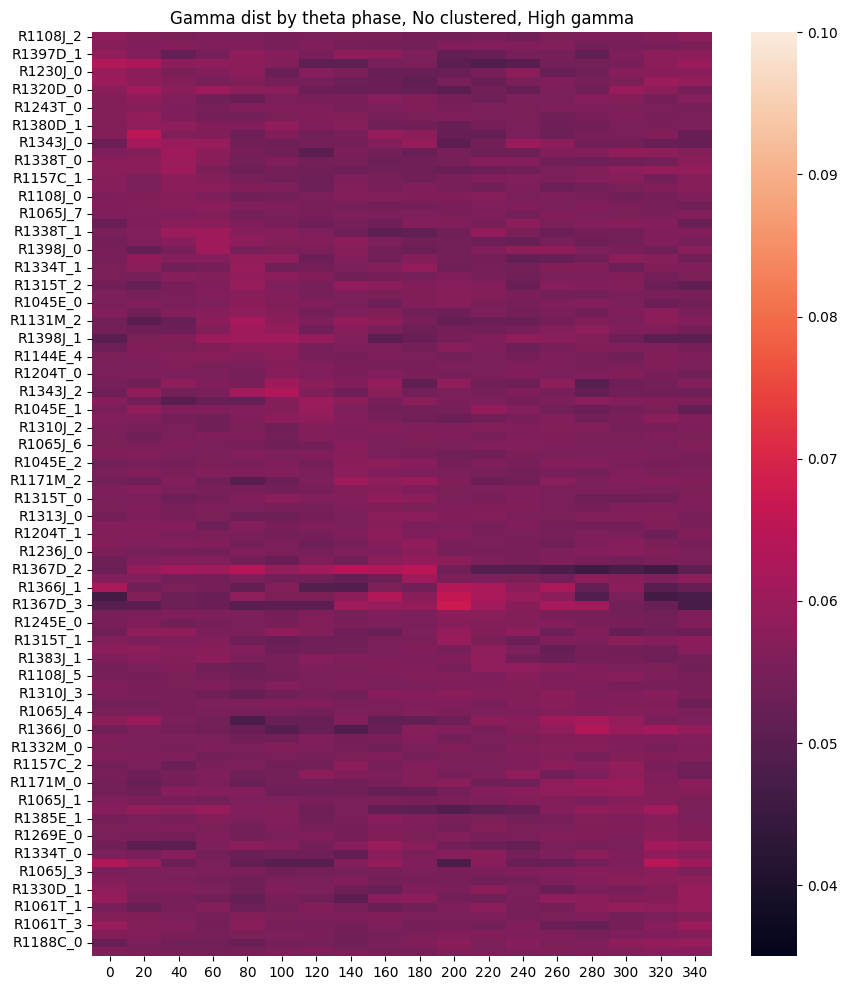

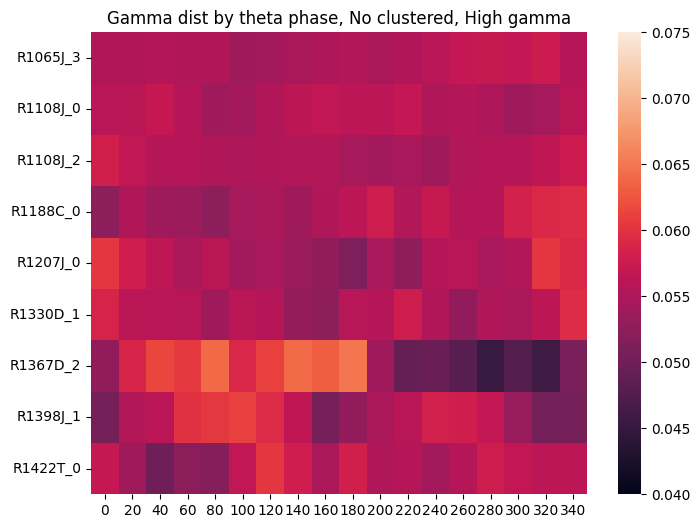

In [60]:
hi = plot_MI_dist(gamma_type, 2, True, recalled=False, remove_low_theta=False, plot=True)

Fraction of sig p vals:  0.08653846153846154


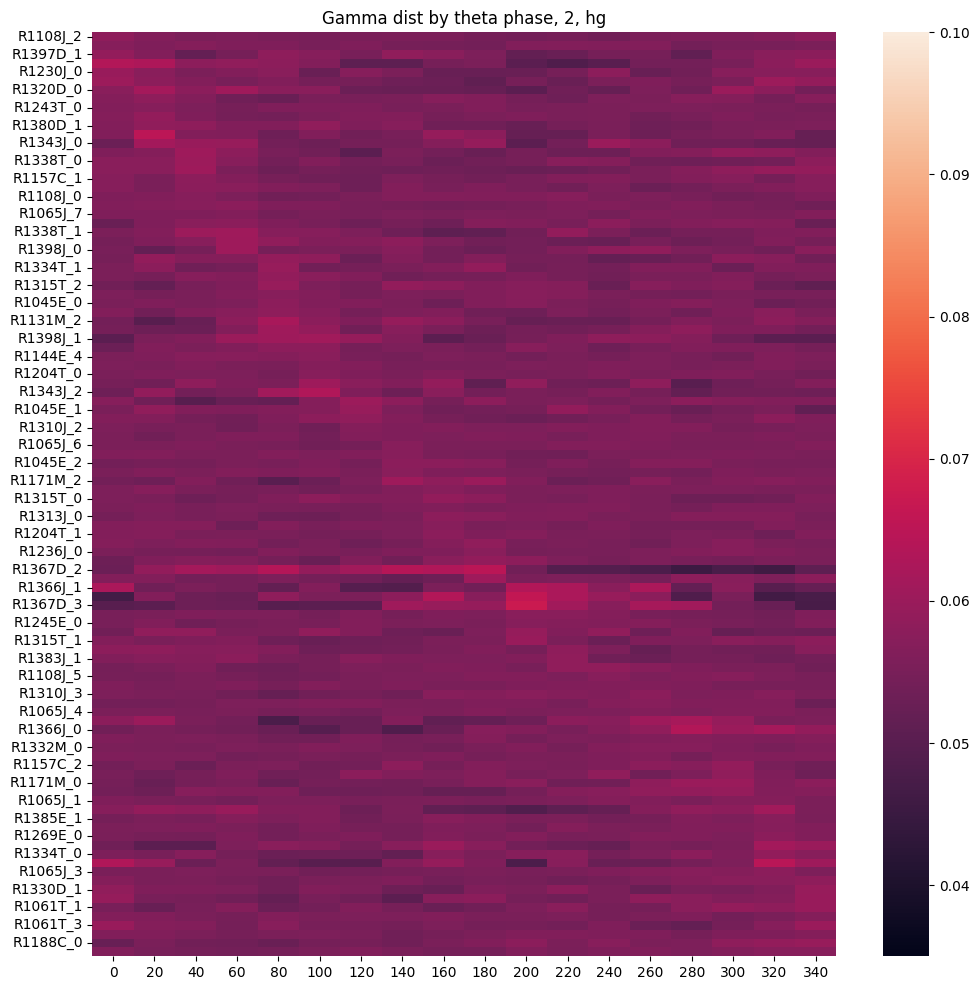

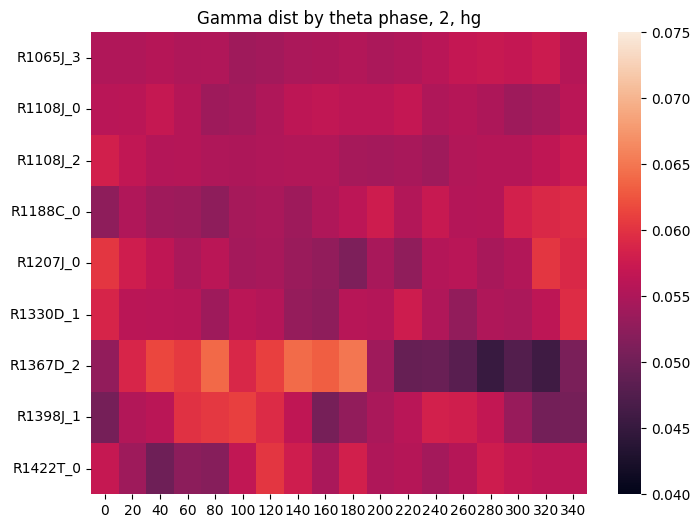

In [43]:
hi = plot_MI_dist(gamma_type, 2, True, recalled=False, remove_low_theta=False, plot=True)

In [44]:
hi.shape

(104, 19)

Plotting recalled data
Fraction of sig p vals:  0.05405405405405406


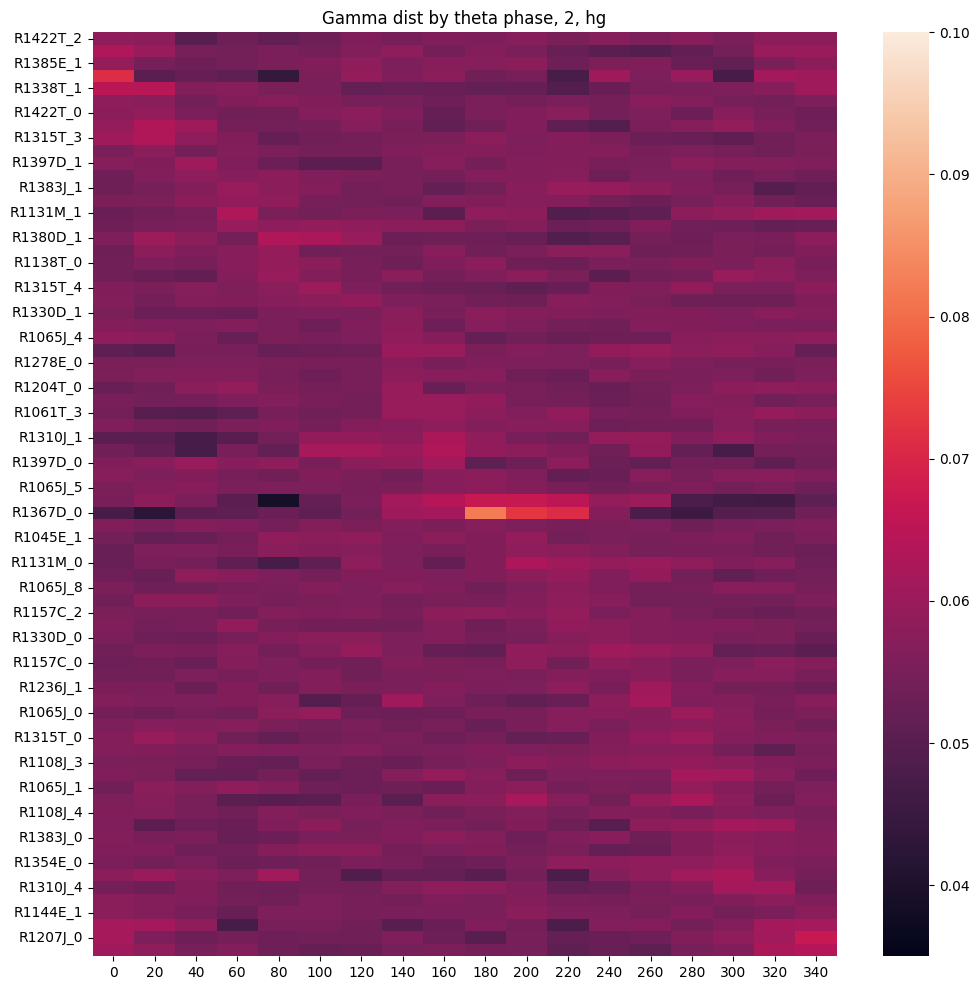

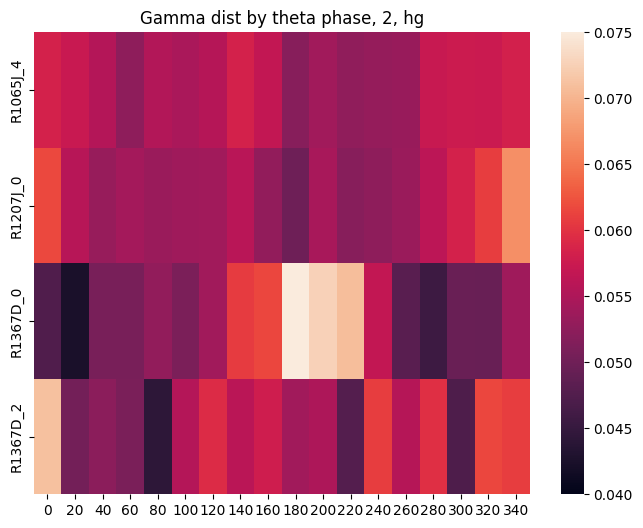

In [39]:
sorted_df_recalled_noclust = plot_MI_dist(gamma_type, 2, True, recalled=True, remove_low_theta=False, plot=True)

In [107]:
wilcoxon(df_comb['clust'], df_comb['noclust'])

WilcoxonResult(statistic=906.0, pvalue=0.37018566979915535)

In [111]:
ttest_rel(df_comb['clust'], df_comb['noclust'])

TtestResult(statistic=-0.01620801621662247, pvalue=0.9871196611239101, df=63)

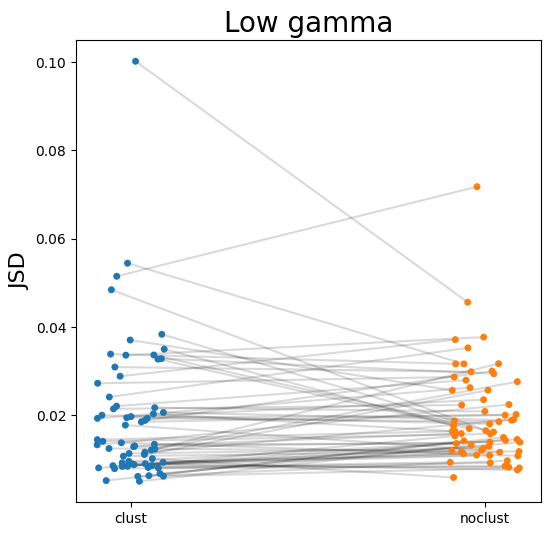

In [105]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.stripplot(df_comb)
i=0
locs1 = ax.get_children()[i].get_offsets()
locs2 = ax.get_children()[i+1].get_offsets()
plt.ylabel('JSD', fontsize=16)
plt.title(gamma_type, fontsize=18)

plt.title("Low gamma", fontsize=20)
for i in range(locs1.shape[0]):
    x = [locs1[i, 0], locs2[i, 0]]
    y = [locs1[i, 1], locs2[i, 1]]
    ax.plot(x, y, color="black", alpha=0.15)